# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [8]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
#from mlfs import config
#if os.path.exists(f"{root_dir}/.env"):
    #settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/aimao/mlfs-book


In [9]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [40]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 20, 23, 52, 25, 262687)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [11]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-20 23:32:09,310 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-20 23:32:09,315 INFO: Initializing external client
2025-11-20 23:32:09,315 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-20 23:32:10,619 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272016


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [12]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=7,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-20 23:32:24,511 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/509659 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/119699 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26583 elapsed<00:00 remaining<?

In [16]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.633173E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [48]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= datetime.now().date()).read()
batch_data=batch_data.sort_values('date', ascending=False)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
recent_df = air_quality_fg.filter(
    (air_quality_fg.city == city) &
    (air_quality_fg.street == street)
).read()
recent_df = recent_df.sort_values('date', ascending=False)
recent_df



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.66s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
3,2025-11-26 00:00:00+00:00,10.00,0.0,18.278645,212.124969,Dublin
5,2025-11-25 00:00:00+00:00,6.35,0.0,11.440978,282.724365,Dublin
4,2025-11-24 00:00:00+00:00,7.30,0.0,18.043148,331.389618,Dublin
2,2025-11-23 00:00:00+00:00,7.20,0.7,31.782108,279.782349,Dublin
1,2025-11-22 00:00:00+00:00,7.05,0.0,16.923830,246.161255,Dublin
0,2025-11-21 00:00:00+00:00,3.85,0.0,10.587918,215.311295,Dublin


In [49]:
import datetime
import pandas as pd

# 初始化 lag 列
batch_data['pm25_lag1'] = 0.0
batch_data['pm25_lag2'] = 0.0
batch_data['pm25_lag3'] = 0.0
batch_data['predicted_pm25'] = 0.0



# 特征列
feature_cols = ['pm25_lag1', 'pm25_lag2', 'pm25_lag3',
                'temperature_2m_mean', 'precipitation_sum',
                'wind_speed_10m_max', 'wind_direction_10m_dominant']

# 按日期排序（确保从最早的日期开始预测）
batch_data = batch_data.sort_values('date').reset_index(drop=True)

# 获取 recent_df 的最近 3 个 PM2.5 值（作为初始 lag）
recent_pm25_list = recent_df['pm25'].tolist()






### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [50]:
for idx in range(len(batch_data)):
    # 设置 lag 特征
    if idx == 0:
        # 第一行：使用 recent_df 的历史数据
        batch_data.at[idx, 'pm25_lag1'] = recent_pm25_list[0]
        batch_data.at[idx, 'pm25_lag2'] = recent_pm25_list[1]
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[2]
    elif idx == 1:
        # 第二行：lag1 用前一行的预测值，lag2/lag3 用 recent_df
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = recent_pm25_list[0]
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[1]
    elif idx == 2:
        # 第三行：lag1/lag2 用前两行的预测值，lag3 用 recent_df
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = batch_data.at[idx-2, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[0]
    else:
        # 后续行：全部用之前的预测值
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = batch_data.at[idx-2, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag3'] = batch_data.at[idx-3, 'predicted_pm25']

    # 提取特征进行预测
    X = batch_data.iloc[[idx]][feature_cols]

    # 预测
    prediction = retrieved_xgboost_model.predict(X)
    batch_data.at[idx, 'predicted_pm25'] = prediction[0]

batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25
0,2025-11-21 00:00:00+00:00,3.85,0.0,10.587918,215.311295,Dublin,19.000000,1.350000,1.650000,6.082029
1,2025-11-22 00:00:00+00:00,7.05,0.0,16.923830,246.161255,Dublin,6.082029,19.000000,1.350000,3.566103
2,2025-11-23 00:00:00+00:00,7.20,0.7,31.782108,279.782349,Dublin,3.566103,6.082029,19.000000,2.495623
3,2025-11-24 00:00:00+00:00,7.30,0.0,18.043148,331.389618,Dublin,2.495623,3.566103,6.082029,2.698911
4,2025-11-25 00:00:00+00:00,6.35,0.0,11.440978,282.724365,Dublin,2.698911,2.495623,3.566103,3.906637
5,2025-11-26 00:00:00+00:00,10.00,0.0,18.278645,212.124969,Dublin,3.906637,2.698911,2.495623,2.599536


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [56]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-21 00:00:00+00:00,3.85,0.0,10.587918,215.311295,Dublin,19.000000,1.350000,1.650000,6.082029,Rathfarnham Road,Ireland,1
1,2025-11-22 00:00:00+00:00,7.05,0.0,16.923830,246.161255,Dublin,6.082029,19.000000,1.350000,3.566103,Rathfarnham Road,Ireland,2
2,2025-11-23 00:00:00+00:00,7.20,0.7,31.782108,279.782349,Dublin,3.566103,6.082029,19.000000,2.495623,Rathfarnham Road,Ireland,3
3,2025-11-24 00:00:00+00:00,7.30,0.0,18.043148,331.389618,Dublin,2.495623,3.566103,6.082029,2.698911,Rathfarnham Road,Ireland,4
4,2025-11-25 00:00:00+00:00,6.35,0.0,11.440978,282.724365,Dublin,2.698911,2.495623,3.566103,3.906637,Rathfarnham Road,Ireland,5
5,2025-11-26 00:00:00+00:00,10.00,0.0,18.278645,212.124969,Dublin,3.906637,2.698911,2.495623,2.599536,Rathfarnham Road,Ireland,6


In [57]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag1                    6 non-null      float64                
 7   pm25_lag2                    6 non-null      float64                
 8   pm25_lag3                    6 non-null      float64                
 9   predicted_pm25               6 non-null      float64                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

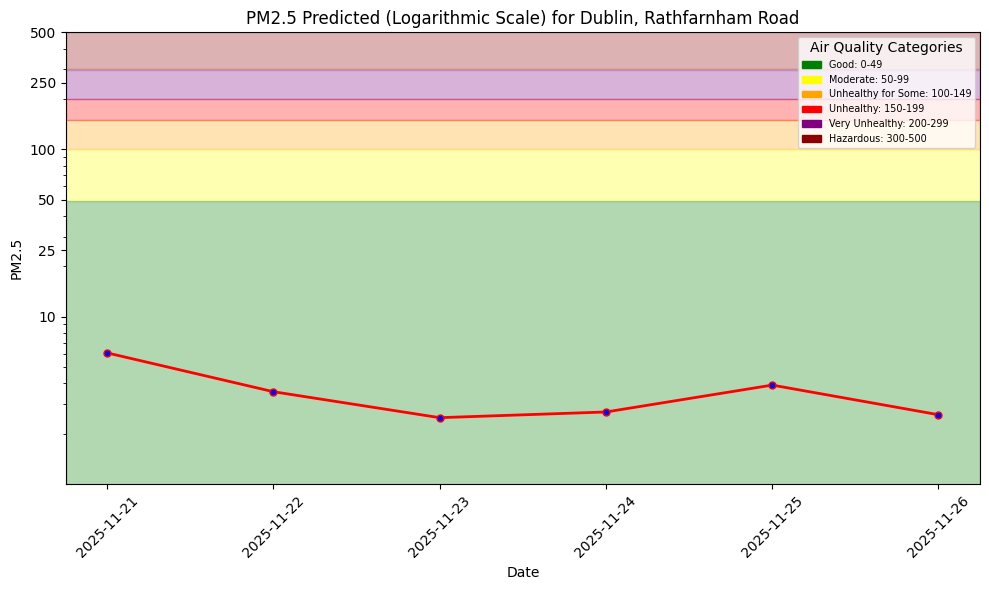

In [58]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [59]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [54]:

monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272016/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-21 00:01:24,441 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-21 00:01:27,592 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-21 00:03:05,646 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-21 00:03:08,813 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-21 00:03:08,960 INFO: Waiting for log aggregation to finish.
2025-11-21 00:03:20,816 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [55]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.82s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-22 00:00:00+00:00,7.05,0.0,16.923830,246.161255,Dublin,19.0,1.35,1.65,9.365277,Rathfarnham Road,Ireland,1
1,2025-11-21 00:00:00+00:00,3.85,0.0,10.587918,215.311295,Dublin,19.0,1.35,1.65,6.082029,Rathfarnham Road,Ireland,1


In [60]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
0,2024-12-01 00:00:00+00:00,0.95,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.000000,1.33,2.25
1,2020-06-04 00:00:00+00:00,1.62,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.000000,1.23,1.27
2,2024-01-31 00:00:00+00:00,0.90,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.630000,1.67,3.20
3,2025-05-04 00:00:00+00:00,1.10,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.200000,1.39,10.31
4,2021-12-14 00:00:00+00:00,2.20,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,3.300000,1.50,1.90
...,...,...,...,...,...,...,...,...,...
2007,2022-01-16 00:00:00+00:00,9.36,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,20.129999,14.55,3.85
2008,2024-08-18 00:00:00+00:00,6.55,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.520000,1.00,0.70
2009,2023-03-31 00:00:00+00:00,3.40,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.900000,1.95,1.42
2010,2025-05-02 00:00:00+00:00,1.39,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,10.310000,7.28,4.29


In [61]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])



hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 


Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272016/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-21 00:06:11,834 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-21 00:06:15,002 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-21 00:07:56,130 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-21 00:07:56,281 INFO: Waiting for log aggregation to finish.
2025-11-21 00:08:04,876 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,5.249334,0.0,12.481153,279.709656,Dublin,19.000000,1.350000,1.650000,4.041791,3.08,Rathfarnham Road,Ireland,1
1,2025-11-18 00:00:00+00:00,5.886833,0.2,25.443750,265.939880,Dublin,4.041791,19.000000,1.350000,2.504301,1.65,Rathfarnham Road,Ireland,1
2,2025-11-19 00:00:00+00:00,2.216000,0.0,21.010712,310.275452,Dublin,2.504301,4.041791,19.000000,3.581463,1.35,Rathfarnham Road,Ireland,1
3,2025-11-20 00:00:00+00:00,3.450000,0.0,17.935081,308.480225,Dublin,3.581463,2.504301,4.041791,1.649091,19.00,Rathfarnham Road,Ireland,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

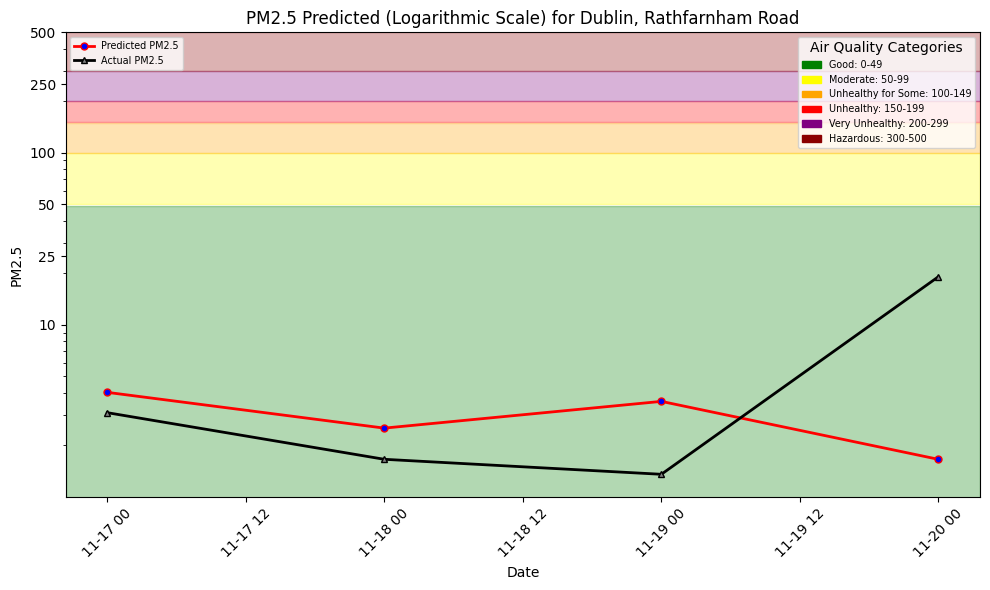

In [62]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [122]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/aimao/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/44958 elap…

Uploading /home/aimao/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/60240…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272016/settings/fb/path/Resources/airquality


---